This code establishes a connection to Apache Spark by creating a SparkSession, which serves as the main entry point for working with Spark data.

It names the application "Laptop Anomaly Exploration" and configures Spark to run locally using all available CPU cores.

This setup enables efficient reading, processing, and analysis of data by leveraging Spark’s powerful distributed computing capabilities.

In [5]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import round

# connect to Spark
spark = SparkSession\
    .builder\
    .appName("Laptop Anomaly Exploration")\
    .master("local[*]") \
    .getOrCreate()

This code runs a SQL query against a Spark-managed table named workshop.laptop_data_scored_user001, selecting all columns but limiting the result to 500 rows.

It then immediately displays the first 30 rows of the query result in the notebook using Spark’s .show() method.

In [2]:
EXAMPLE_SQL_QUERY = "SELECT * FROM workshop.laptop_data_scored_user001 limit 500"
df = spark.sql(EXAMPLE_SQL_QUERY)
df.show(30)

Hive Session ID = 2101dfaf-2c17-4ab1-b113-e10be43406fc


+---------+-------------+-------------+-------------+--------------------+-------+
|laptop_id|     latitude|    longitude|  temperature|            event_ts|anomaly|
+---------+-------------+-------------+-------------+--------------------+-------+
|       94|44.0204015177|12.2161323199|48.1630819428|2025-08-11 12:50:...|      0|
|       38|38.7495422551|9.04318666664|44.9937956477|2025-08-11 12:50:...|      0|
|       26|41.3733280767|16.3997761068|71.9189388459|2025-08-11 12:50:...|      0|
|       32|38.1776104107|11.6740690634|82.7245776135|2025-08-11 12:50:...|      0|
|       27|45.5183560318|9.64352565124|85.5053976708|2025-08-11 12:50:...|      0|
|       79|45.8718800439|11.9607649283|71.0335944413|2025-08-11 12:50:...|      0|
|       89|41.3197727723| 13.749112918|14.1044385284|2025-08-11 12:50:...|      0|
|       57|36.8513304583| 13.483611388|42.4288375165|2025-08-11 12:50:...|      0|
|       51|38.3663038348|   10.5832698|80.1432138273|2025-08-11 12:50:...|      0|
|   

Display only the Anomalies 

In [3]:
anomalies_df = df.filter(df.anomaly == 1)
anomalies_df.show(30)

+---------+-------------+-------------+-------------+--------------------+-------+
|laptop_id|     latitude|    longitude|  temperature|            event_ts|anomaly|
+---------+-------------+-------------+-------------+--------------------+-------+
|       13|45.7621317288|11.5206136168|98.2832524895|2025-08-11 12:50:...|      1|
|       70|43.3713118876|8.03887356288|17.9872967321|2025-08-11 12:50:...|      1|
|       78|39.5641555405|16.2703807027|16.0185806662|2025-08-11 12:50:...|      1|
|       40|44.9885254424|16.8927225118|30.2309619624|2025-08-11 12:50:...|      1|
|       58|36.1417383266|9.46505680737|35.4771945739|2025-08-11 12:50:...|      1|
|        3|45.9647062867|16.0153227233|89.9041984055|2025-08-11 12:50:...|      1|
|       51|36.0025148278|12.6469091568|83.0269004051|2025-08-11 12:50:...|      1|
|       30|43.3325321861|8.02782665587|99.6228085044|2025-08-11 12:50:...|      1|
|       26|45.9974927074|13.5477691867|87.4216942644|2025-08-11 12:50:...|      1|
|   

In this analysis, we use Apache Spark to identify geographic hotspots of laptop temperature anomalies. By rounding the latitude and longitude coordinates to create a location grid, we group anomalous data points within these grid cells. We then count the number of anomalies in each cell to highlight areas where unusually high or low laptop temperatures frequently occur. This aggregated view helps reveal patterns or clusters of potential hardware or environmental issues across different regions. Finally, by converting the results to a Pandas DataFrame, we visualize these hotspots on a scatter plot, where the size of each point corresponds to the number of anomalies in that area. This approach leverages Spark’s powerful data processing and enables effective exploration and monitoring of anomalies at scale.

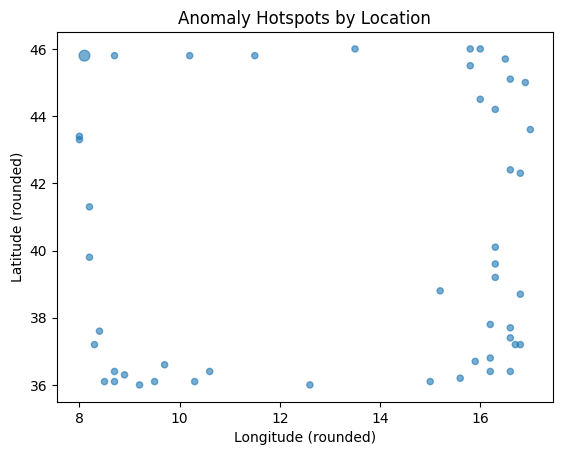

In [6]:
import matplotlib.pyplot as plt

df_grid = df.withColumn("lat_grid", round("latitude", 1)) \
            .withColumn("lon_grid", round("longitude", 1))


anomaly_counts = df_grid.filter(df_grid.anomaly == 1) \
                       .groupBy("lat_grid", "lon_grid") \
                       .count() \
                       .orderBy("count", ascending=False)



pdf = anomaly_counts.toPandas()

plt.scatter(pdf['lon_grid'], pdf['lat_grid'], s=pdf['count']*20, alpha=0.6)
plt.xlabel("Longitude (rounded)")
plt.ylabel("Latitude (rounded)")
plt.title("Anomaly Hotspots by Location")
plt.show()


In [8]:
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Convert Pandas DataFrame to GeoDataFrame with Point geometry
geometry = [Point(xy) for xy in zip(pdf['lon_grid'], pdf['lat_grid'])]
geo_df = gpd.GeoDataFrame(pdf, geometry=geometry)

# Load world map dataset
world = geodatasets.load_dataset("naturalearth_lowres")

# Plot the base world map
ax = world.plot(figsize=(15, 10), color='lightgrey', edgecolor='white')

# Plot anomalies on top, sizing markers by count
geo_df.plot(ax=ax,
            markersize=geo_df['count'] * 20,
            color='red',
            alpha=0.6,
            marker='o',
            label='Anomalies')

plt.title("Anomaly Hotspots by Location on World Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


AttributeError: module 'geodatasets' has no attribute 'load_dataset'